# DQN: Deep Q-Network

_Ismaël Bonneau_

Dans ce notebook nous allons vous présenter le modèle de renforcement DQN (pour Deep Q-Network) qui permet de mélanger Q-learning et deep learning.

In [40]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Commençons par un petit jeu simple, cartpole

Ce jeu est disponible dans l'environnement gym. Le principe est simple: faire tenir en équilibre un baton posé à la verticale sur un chariot. Pour ça, il faut bouger le chariot soit à droite, soit à gauche. Le jeu se termine quand le baton est tombé (on considère qu'au bout d'une inclinaison à 30 degrés, il est tombé).

Ce jeu est modélisé par des états codés comme un vecteur en 4 dimensions modélisant 4 mesures physiques (position du chariot, angles...) et deux actions possible: bouger d'un cran vers la droite, bouger d'un cran vers la gauche.

<img src="images/cartpole.png" width="500">

Configurons l'environnement cartpole avec gym:

In [26]:
import gym

env = gym.make('CartPole-v1')
outdir = 'TP4/cartpole-v0/DQN-agent-results'
envm = gym.wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
env.seed(0)
env.verbose = False

Voyons à quoi ressemble un état du jeu:

In [8]:
print("un état: ", envm.reset())
print("nombre d'actions possibles ", env.action_space.n)

un état:  [-0.03975157  0.01730763 -0.01074233  0.01698461]
nombre d'actions possibles  2


### Apprentissage

Commençons par importer notre agent. On lui donne un certain nombre d'hyper paramètres, qui sont:

- la capacité de la mémoire
- le nombre d'étapes après lequel mettre à jour la fonction target
- le discount factor
- le learning rate
- et tout un autre tas de paramètres...

In [27]:
from TP4.DQNAgentCartpole import DQN

MEMORY_CAPACITY = 2000
N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]
TARGET_REPLACE_ITER = 100
GAMMA = 0.9
NN_layers = [32]

dqn = DQN(N_STATES, N_ACTIONS, MEMORY_CAPACITY)

In [28]:
episode_count = 500

reward = 0
done = False
np.random.seed(42)
rsum = 0
rsums = []
steps = []

for i in range(episode_count):
    obs = envm.reset()
    j = 0
    rsum = 0
    while True:
        action = dqn.choose_action(obs)
        obs_, reward, done, _ = envm.step(action)
        #s_, r, done, info = env.step(a)
        r = reward
        x, x_dot, theta, theta_dot = obs_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2
    
        dqn.store_transition(obs, action, r, obs_)
        rsum = (GAMMA**j * rsum) + r
        j += 1
            
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
                
        obs = obs_
        
        if done:
            rsums.append(rsum)
            steps.append(j)
            if i % 100 == 0:
                print("Episode : " + str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions")
            break

Episode : 0 rsum=-0.6568216581761795, 10 actions
Episode : 100 rsum=-0.5810713181923501, 9 actions
Episode : 200 rsum=-0.4147491654502854, 9 actions
Episode : 300 rsum=0.4092497466655439, 500 actions
Episode : 400 rsum=0.40782989814201376, 500 actions


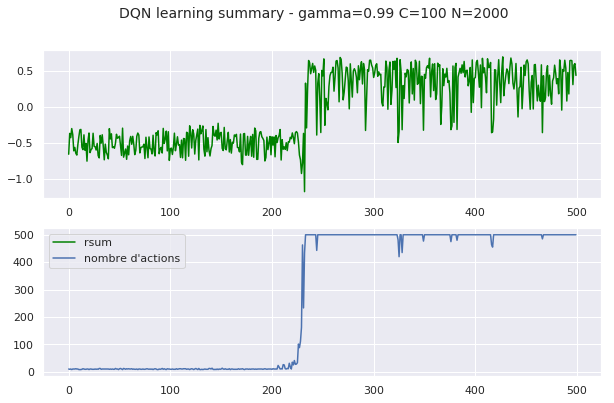

In [67]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,6))
fig.suptitle('DQN learning summary - gamma=0.99 C=100 N=2000', fontsize=14)
a, = ax1.plot(list(range(episode_count)), rsums, label="rsum", color="green")
b, = ax2.plot(list(range(episode_count)), steps, label="nombre d'actions")
plt.legend(handles=[a, b])
plt.show()